In [4]:
import itertools
from itertools import combinations, product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.multitest import multipletests

from hyppo.independence import Dcorr
from hyppo.tools import chi2_approx


def flatten(l):
    return [item for sublist in l for item in sublist]

In [169]:
volumes = pd.read_csv("../data/processed/volumes.csv")

d = 3

vols = np.load("../data/embeddings/vol_embed.npy")
vols = vols[:, :, :d]

fa = np.load("../data/embeddings/fa_embed.npy")
fa = fa[:, :, :d]

vols = np.concatenate([vols, fa], axis=2)

In [170]:
genotypes = [
    [],
    ("Genotype_APOE22", "Genotype_APOE33"),
    ("Genotype_APOE22", "Genotype_APOE44"),
    ("Genotype_APOE33", "Genotype_APOE44"),
    ("Genotype_APOE22", "Genotype_APOE33", "Genotype_APOE44"),
]
sex = [["Sex_Female", "Sex_Male"], ["Sex_Female"], ["Sex_Male"], []]
diet = [["Diet_Control", "Diet_HFD"], ["Diet_Control"], ["Diet_HFD"], []]
allele = [["Allele_HN", "Allele_Non-HN"], ["Allele_HN"], ["Allele_Non-HN"], []]
age = [["Age_Above", "Age_Below"], ["Age_Above"], ["Age_Below"], []]

groups = list(product(genotypes, sex, allele, age))

lengths = [list(map(len, sublist)) for sublist in groups]
filter_list = [any(list(map(lambda x: x >= 2, sublist))) for sublist in lengths]

TEST_LIST = list(itertools.compress(groups, filter_list))
TEST_LIST = [list(itertools.chain.from_iterable(i)) for i in TEST_LIST]

TEST_LIST = [i + ["Diet_Control"] for i in TEST_LIST]

In [171]:
meta = pd.read_csv("../data/processed/meta.csv")

# Split age into above median ("AM") or blow median ("BM")
# median = meta.groupby(["Genotype", "Allele"]).median(numeric_only=True)
median = meta[meta.Diet == "Control"].groupby(["Genotype"]).median(numeric_only=True)

# replace with true, false based on median by genotype
for g, med in median.iterrows():
    rows = meta.loc[meta.Genotype == g, "Age"] <= med.values[0]
    meta.loc[meta.Genotype == g, "Age"] = rows

for idx, row in meta.iterrows():
    age = row["Age"]
    if age:
        meta.loc[idx, "Age"] = "Below"
    else:
        meta.loc[idx, "Age"] = "Above"

# Column labels
# APOE2, APOE3, APOE4, NON-HN, HN, Female, Male
enc = OneHotEncoder(handle_unknown="ignore")
tmp = meta[["Genotype", "Sex", "Diet", "Allele", "Age"]]
enc.fit(tmp)
lookup = {key: val for key, val in zip(enc.get_feature_names_out(), range(12))}

multiway_table = enc.transform(tmp).toarray()

# %%
# Run node wise

res = []

count = 0
for test in TEST_LIST:
    lookup_codes = [lookup[i] for i in test]
    test_multiway_table = multiway_table[:, lookup_codes]
    maximum = np.max(test_multiway_table.sum(axis=1))

    idx = test_multiway_table.sum(axis=1) == maximum

    x = vols[idx]
    y = test_multiway_table[idx]
    n = x.shape[0]

    if n < 20:
        continue
    else:
        count += 1

    tmp_res = []
    for i in range(x.shape[1]):
        stat, pval = chi2_approx(Dcorr().statistic, x[:, i], y)
        tmp_res.append(pval)

    # indicators
    apoe2 = True if "Genotype_APOE22" in test else False
    apoe3 = True if "Genotype_APOE33" in test else False
    apoe4 = True if "Genotype_APOE44" in test else False
    genotype_indicator = any([apoe2, apoe3, apoe4])

    female = True if "Sex_Female" in test else False
    male = True if "Sex_Male" in test else False
    sex_indicator = female and male

    hn = True if "Allele_HN" in test else False
    non_hn = True if "Allele_Non-HN" in test else False
    hn_indicator = hn and non_hn

    age_above = True if "Age_Above" in test else False
    age_below = True if "Age_Below" in test else False
    age_indicator = age_above and age_below

    multiway = (
        True
        if (genotype_indicator + sex_indicator + hn_indicator + age_indicator) >= 2
        else False
    )

    res.append(
        [
            multiway,
            apoe2,
            apoe3,
            apoe4,
            female,
            male,
            hn,
            non_hn,
            age_above,
            age_below,
            n,
            *tmp_res,
        ]
    )

columns = [
    "Multiway",
    "APOE2",
    "APOE3",
    "APOE4",
    "Female",
    "Male",
    "HN",
    "Non-HN",
    "Age-Above",
    "Age-Below",
    "N",
] + volumes.structure.to_list()

df = pd.DataFrame(res, columns=columns)

K = []

for idx, row in df.iterrows():
    total = row[["APOE2", "APOE3", "APOE4"]].sum()
    if total == 0:
        total = 1
    if row[["Female", "Male"]].sum() > 0:
        total *= row[["Female", "Male"]].sum()
    if row[["HN", "Non-HN"]].sum() > 0:
        total *= row[["HN", "Non-HN"]].sum()
    if row[["Age-Above", "Age-Below"]].sum() > 0:
        total *= row[["Age-Above", "Age-Below"]].sum()
    K.append(total)

df["K"] = K

df.sort_values(
    by=["N", "K", "Female", "Male", "Age-Above", "Age-Below", "Non-HN", "HN", "K"],
    inplace=True,
    ascending=False,
)

i_new = []
for idx, row in df.iterrows():
    K = row["K"]
    N = row["N"]
    if row["Multiway"]:
        multiway = "X"
    else:
        multiway = " "

    geno_row = row[["APOE2", "APOE3", "APOE4"]]
    if np.all(geno_row == [True, True, True]):
        genotype = "APOE 2, 3, 4"
    elif np.all(geno_row == [True, True, False]):
        genotype = "APOE 2, 3,  "
    elif np.all(geno_row == [True, False, True]):
        genotype = "APOE 2,    4"
    elif np.all(geno_row == [False, True, True]):
        genotype = "APOE    3, 4"
    else:
        genotype = "            "

    gender_row = row[["Female", "Male"]]
    if np.all(gender_row == [True, True]):
        gender = "F, M"
    elif np.all(gender_row == [False, True]):
        gender = "   M"
    elif np.all(gender_row == [True, False]):
        gender = "F   "
    else:
        gender = "    "

    allele_row = row[["HN", "Non-HN"]]
    if np.all(allele_row == [True, True]):
        allele = "HN, Non-HN"
    elif np.all(allele_row == [False, True]):
        allele = "    Non-HN"
    elif np.all(allele_row == [True, False]):
        allele = "HN        "
    else:
        allele = "          "

    age_row = row[["Age-Above", "Age-Below"]]
    if np.all(age_row == [True, True]):
        age = "Above, Below"
    elif np.all(age_row == [False, True]):
        age = "       Below"
    elif np.all(age_row == [True, False]):
        age = "Above       "
    else:
        age = "            "

    # index = f"{K:2d} | {N:3d} | {multiway} | {genotype} | {gender} | {age} | {allele}"
    index = f"{genotype} | {gender} | {age} | {allele}"

    i_new.append(index)


df.index = i_new

In [172]:
pvalues = df.iloc[:, 11:-1].copy()

sig, corrected_pvals, b, alpha = multipletests(
    pvalues.values.ravel(), method="bonferroni"
)

pvalues.iloc[:, :] = corrected_pvals.reshape(count, -1)
mask = np.select([pvalues < 0.05, pvalues >= 0.05], ["X", ""], default=pvalues)

node_labels = pd.read_excel("../data/raw/CHASSSYMM3AtlasLegends.xlsx")[:-1]
node_labels.loc[:, "Abbreviation"] = node_labels.loc[:, "Abbreviation"].replace(
    "PHD_PaMP_Post_and_LatHy", "PaMP_LatHy"
)
# node_labels["Abbreviation-Hemisphere"] = (
#     node_labels["Abbreviation"] + "-" + node_labels["Hemisphere"].str[0]
# )

node_labels["Abbreviation-Hemisphere"] = node_labels["Abbreviation"]

left_nodes = (node_labels["Hemisphere"] == "Left").values
right_nodes = (node_labels["Hemisphere"] == "Right").values

nodes_to_choose = ((pvalues <= 0.05).sum() >= 1).values
# pvalues.columns = node_labels["Abbreviation"].values
pvalues.columns = node_labels["Abbreviation-Hemisphere"].values
# pvalues = pvalues[sorted(pvalues.columns)]

left_idx = nodes_to_choose & left_nodes
right_idx = nodes_to_choose & right_nodes

rows_to_choose = ((pvalues <= 0.05).sum(axis=1) >= 1).values

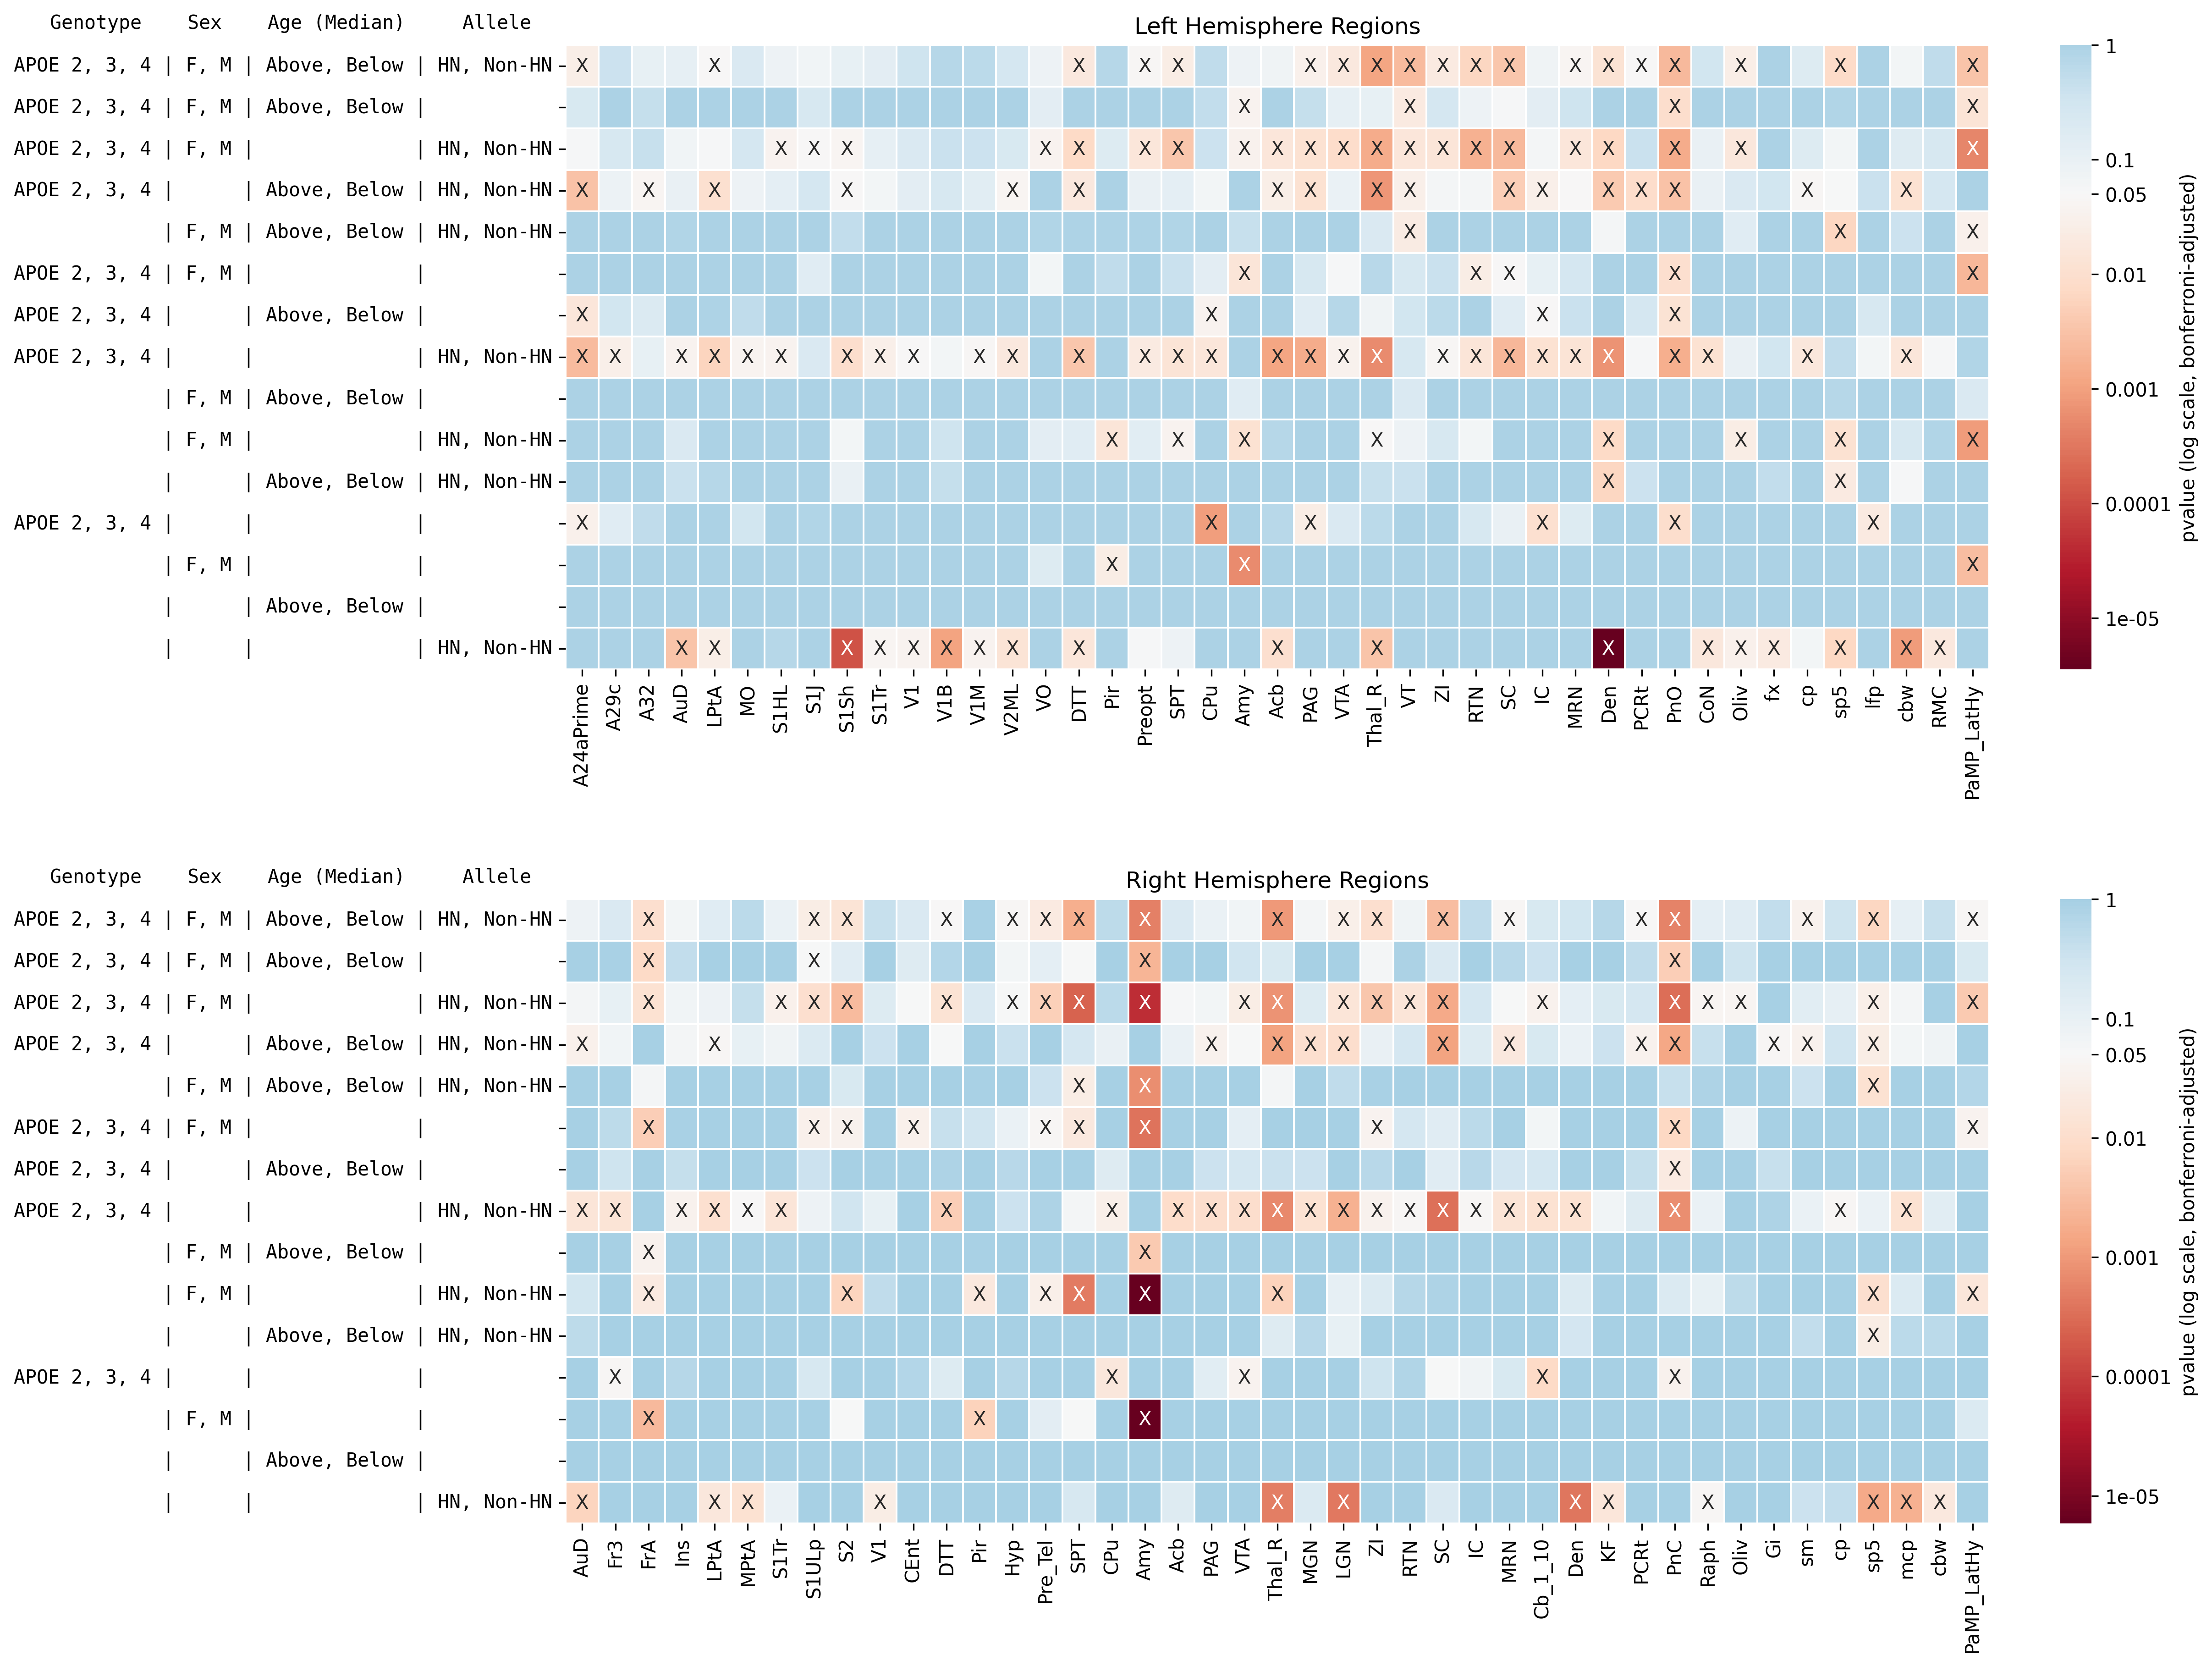

In [173]:
rows_to_choose = np.arange(15)

tmp = pvalues.iloc[rows_to_choose]

nodes_to_choose = ((tmp <= 0.05).sum() >= 1).values 
# pvalues.columns = node_labels["Abbreviation"].values
tmp.columns = node_labels["Abbreviation-Hemisphere"].values
# pvalues = pvalues[sorted(pvalues.columns)]

left_idx = nodes_to_choose & left_nodes
right_idx = nodes_to_choose & right_nodes


fig = plt.figure(layout="constrained", figsize=(16, 12), dpi=300)
subfigs = fig.subfigures(2, 1, hspace=0.07)

left_axes = subfigs[0].subplots(1, 1)
right_axes = subfigs[1].subplots(1, 1)

cbar_ticks = [
    0.000000001,
    0.00000001,
    0.0000001,
    0.000001,
    0.00001,
    0.0001,
    0.001,
    0.01,
    0.05,
    0.1,
    1,
]

for ax, nodes_to_choose, title in zip(
    [left_axes, right_axes],
    [left_idx, right_idx],
    ["Left Hemisphere Regions", "Right Hemisphere Regions"],
):
    sns.heatmap(
        tmp.transform("log10").iloc[rows_to_choose, nodes_to_choose],
        ax=ax,
        annot=mask[:, nodes_to_choose][rows_to_choose, :],
        fmt="",
        square=False,
        linewidths=0.5,
        center=np.log10(0.05),
        cbar_kws={"ticks": np.log10(cbar_ticks)},
        cmap="RdBu",
        # xticklabels=False,
    )
    ax.set_title(title)

    ax.collections[0].colorbar.set_label("pvalue (log scale, bonferroni-adjusted)")
    ax.collections[0].colorbar.set_ticklabels(cbar_ticks)
    ax.set_yticklabels(
        ax.get_yticklabels(), ha="right", fontdict={"family": "monospace"}
    )

    text_dict = dict(
        ha="right",
        va="bottom",
        transform=ax.transAxes,
        fontdict={"family": "monospace"},
    )

    bbox = ax.get_yticklabels()[0].get_window_extent()
    x, _ = ax.transAxes.inverted().transform([bbox.x0, bbox.y0])

    # ax.set_title(
    #     "K     N          Genotype     Sex    Age (Median)     Allele", x=0, **text_dict
    # )

    header = "Genotype    Sex    Age (Median)     Allele   "
    ax.text(0, 1.02, header, **text_dict)
    # ax.set_xlabel("Brain Regions")

fig.savefig(
    f"../results/figures/allele_tests_significant_only.png",
    bbox_inches="tight",
    dpi=300,
)

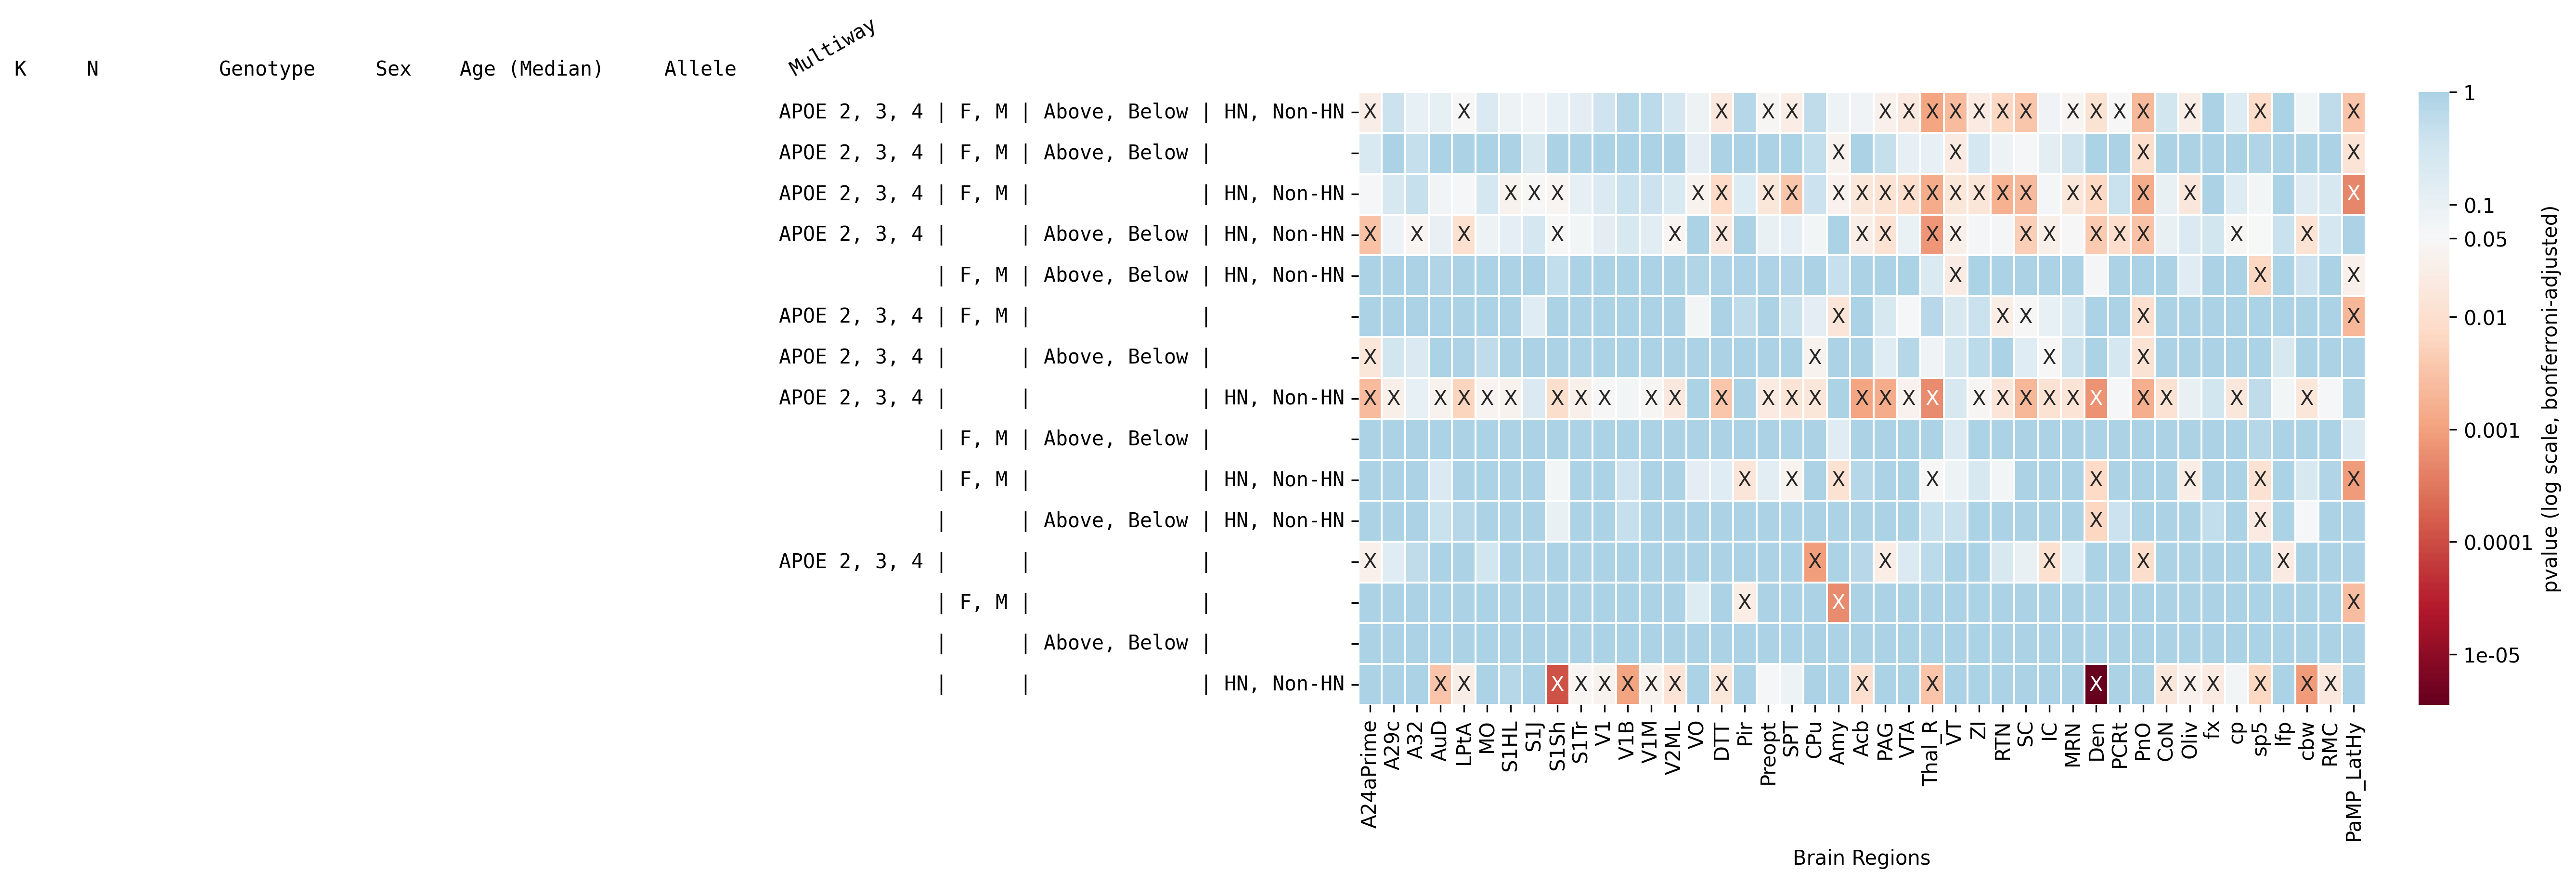

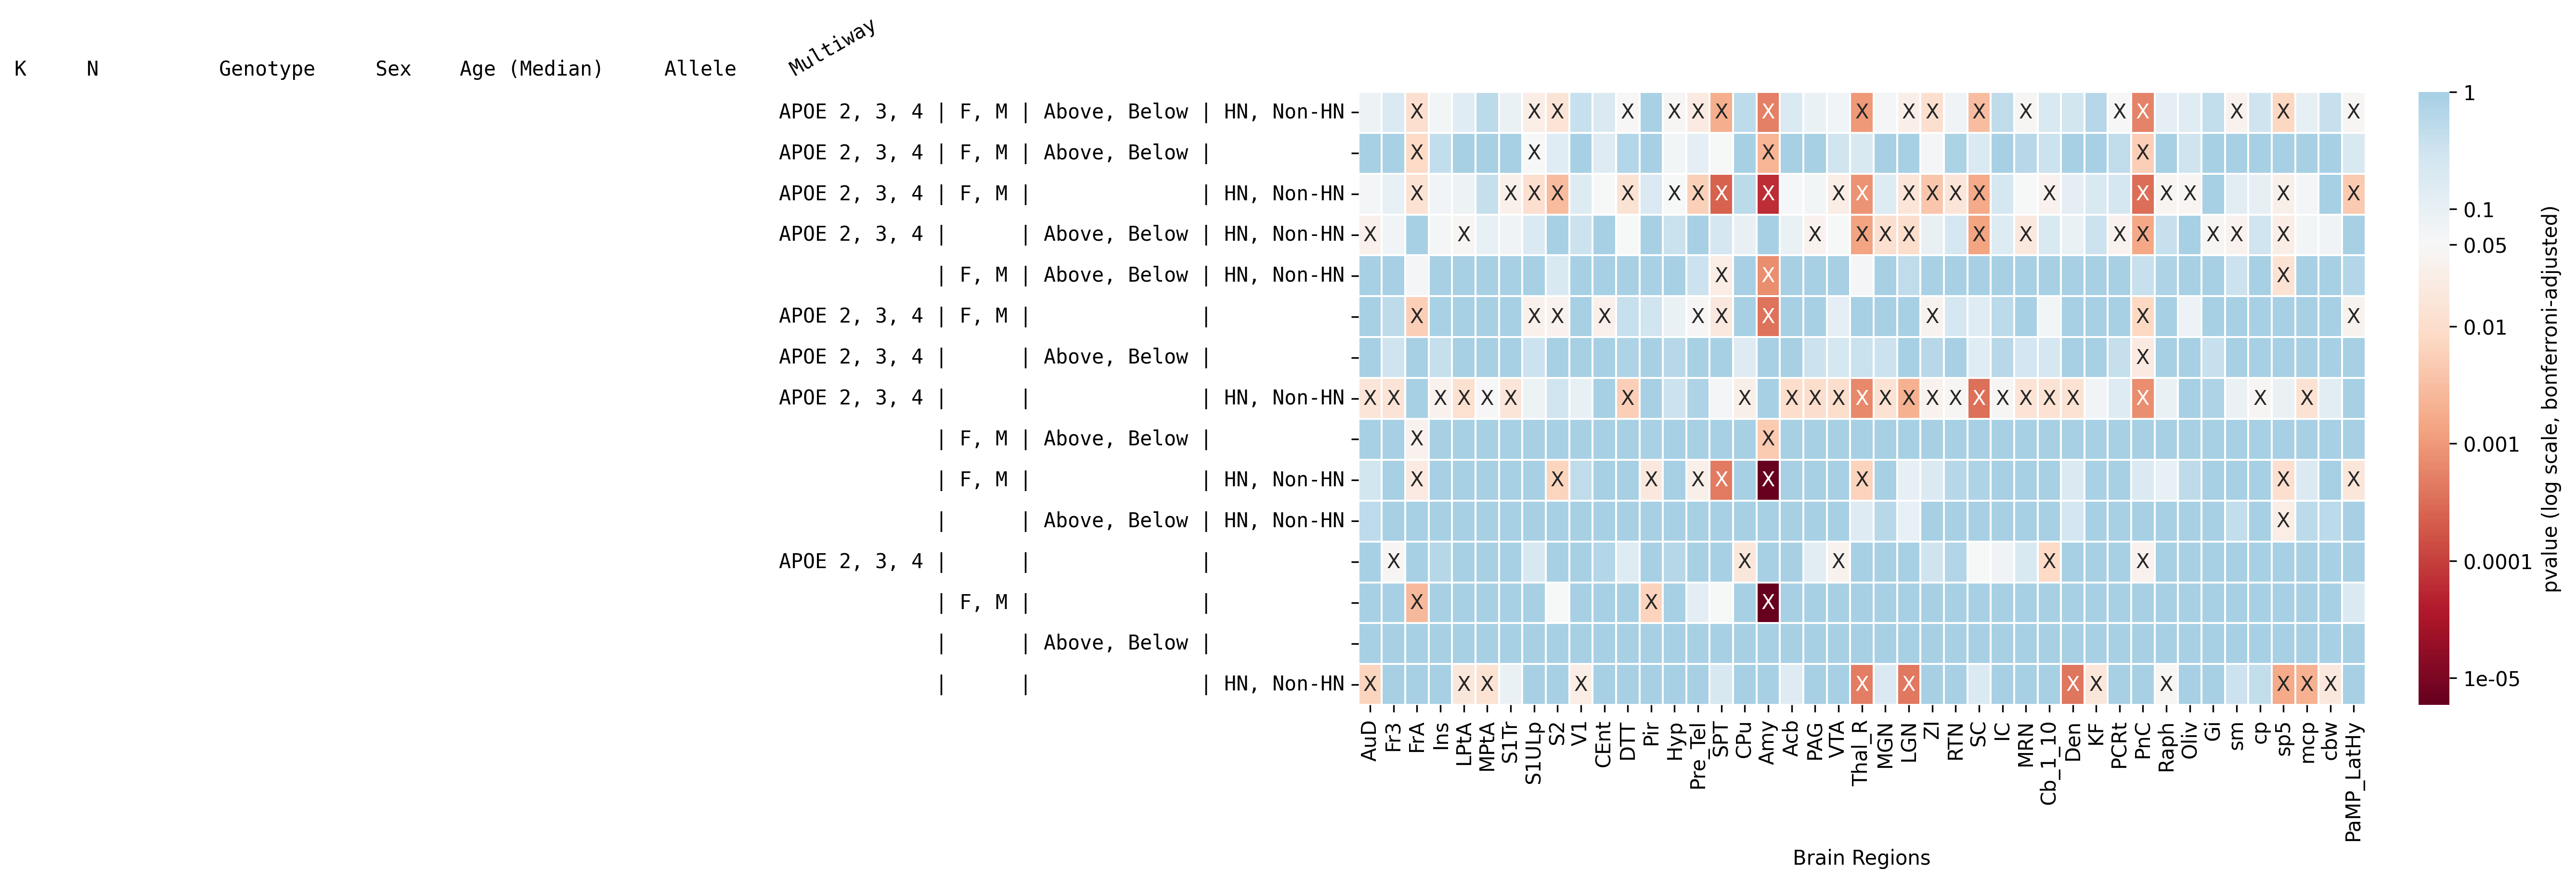

In [174]:
rows_to_choose = np.arange(15)

tmp = pvalues.iloc[rows_to_choose]

nodes_to_choose = ((tmp <= 0.05).sum() >= 1).values
# pvalues.columns = node_labels["Abbreviation"].values
tmp.columns = node_labels["Abbreviation-Hemisphere"].values
# pvalues = pvalues[sorted(pvalues.columns)]

left_idx = nodes_to_choose & left_nodes
right_idx = nodes_to_choose & right_nodes


for idx, nodes_to_choose in enumerate([left_idx, right_idx]):
    cbar_ticks = [
        0.000000001,
        0.00000001,
        0.0000001,
        0.000001,
        0.00001,
        0.0001,
        0.001,
        0.01,
        0.05,
        0.1,
        1,
    ]

    fig, ax = plt.subplots(
        figsize=(16, 6),
        dpi=300,
        constrained_layout=True,
    )
    sns.heatmap(
        tmp.transform("log10").iloc[rows_to_choose, nodes_to_choose],
        ax=ax,
        annot=mask[:, nodes_to_choose][rows_to_choose, :],
        fmt="",
        square=False,
        linewidths=0.5,
        center=np.log10(0.05),
        cbar_kws={"ticks": np.log10(cbar_ticks)},
        cmap="RdBu",
        # xticklabels=False,
    )

    ax.collections[0].colorbar.set_label("pvalue (log scale, bonferroni-adjusted)")
    ax.collections[0].colorbar.set_ticklabels(cbar_ticks)
    ax.set_yticklabels(
        ax.get_yticklabels(), ha="right", fontdict={"family": "monospace"}
    )

    text_dict = dict(
        ha="right",
        va="bottom",
        transform=ax.transAxes,
        fontdict={"family": "monospace"},
    )

    header = "K     N          Genotype     Sex    Age (Median)     Allele"
    ax.text(-0.6175, 1.02, header, **text_dict)
    ax.text(-0.475, 1.02, "Multiway", rotation=30, **text_dict)

    ax.set_xlabel("Brain Regions")
    # ax.set_title("Effect of HN Allele")

    # fig.savefig(
    #     f"../results/figures/allele_tests_significant_only_{idx}.png",
    #     bbox_inches="tight",
    #     dpi=300,
    # )

In [ ]:
rows_to_choose = np.arange(15)

tmp = pvalues.iloc[rows_to_choose]

nodes_to_choose = ((tmp <= 0.05).sum() >= 1).values
# pvalues.columns = node_labels["Abbreviation"].values
tmp.columns = node_labels["Abbreviation-Hemisphere"].values
# pvalues = pvalues[sorted(pvalues.columns)]

left_idx = nodes_to_choose & left_nodes
right_idx = nodes_to_choose & right_nodes

cbar_ticks = [
    0.000000001,
    0.00000001,
    0.0000001,
    0.000001,
    0.00001,
    0.0001,
    0.001,
    0.01,
    0.05,
    0.1,
    1,
]

fig, ax = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(12, 10),
    dpi=300,
    constrained_layout=True,
    gridspec_kw={"width_ratios": [1, 0.05]},
)
sns.heatmap(
    tmp.transform("log10").iloc[rows_to_choose, left_idx],
    ax=ax[0, 0],
    annot=mask[:, left_idx][rows_to_choose, :],
    fmt="",
    square=False,
    linewidths=0.5,
    center=np.log10(0.05),
    cbar_kws={"ticks": np.log10(cbar_ticks)},
    cbar_ax=ax[0, 1],
    cmap="RdBu",
    # xticklabels=False,
)

# ax[0, 1].collections[0].colorbar.set_label("pvalue (log scale, bonferroni-adjusted)")
# ax[0, 1].collections[0].colorbar.set_ticklabels(cbar_ticks)
ax[0, 0].set_yticklabels(
    ax[0, 0].get_yticklabels(), ha="right", fontdict={"family": "monospace"}
)

text_dict = dict(
    ha="left",
    va="bottom",
    transform=ax[0, 0].transAxes,
    fontdict={"family": "monospace"},
)

header = "K    N         Genotype     Sex    Age (Median)      Diet"
ax[0, 0].text(-0.3175, 1.02, header, **text_dict)


sns.heatmap(
    tmp.transform("log10").iloc[rows_to_choose, right_idx],
    ax=ax[1, 0],
    annot=mask[:, right_idx][rows_to_choose, :],
    fmt="",
    square=False,
    linewidths=0.5,
    center=np.log10(0.05),
    cbar_kws={"ticks": np.log10(cbar_ticks)},
    cbar_ax=ax[1, 1],
    cmap="RdBu",
    # xticklabels=False,
)

# ax[1, 1].collections[0].colorbar.set_label("pvalue (log scale, bonferroni-adjusted)")
# ax[1, 1].collections[0].colorbar.set_ticklabels(cbar_ticks)
ax[1, 0].set_yticklabels(
    ax[1, 0].get_yticklabels(), ha="right", fontdict={"family": "monospace"}
)


# ax.set_xlabel("Brain Regions")
# ax.set_title("Effect of HN Allele")


# fig.savefig(
#     "../results/figures/allele_tests_significant_only.png", bbox_inches="tight", dpi=300
# )

# fig.savefig(
#     "../results/figures/allele_tests_significant_only.svg", bbox_inches="tight", dpi=300
# )

In [339]:
count

207

In [427]:
regions = []
idxes = []

for idx, row in tmp.iterrows():
    row = row[row <= 0.05]
    regions.append(list(np.argsort(row)[:5].index))

    idxes.append(idx)

regions = pd.DataFrame([regions[0]] + regions[-4:-1] + [regions[-1]])

regions = regions.T

regions.columns = ["Genotype+Sex+Age+Allele", "Genotype", "Sex", "Age", "Allele"]

In [428]:
for idx, row in regions.iterrows():
    for key, val in row.items():
        if val is None:
            continue
        splits = val.split("-")
        if splits[1] == "L":
            hemi = "Left"
        else:
            hemi = "Right"
        new_val = node_labels[
            (node_labels.Abbreviation == splits[0]) & (node_labels.Hemisphere == hemi)
        ].Structure.iloc[0]
        new_val = new_val + "-" + splits[1]
        new_val = new_val.replace("_", " ")
        row[key] = new_val

In [431]:
regions

,Genotype+Sex+Age+Allele,Genotype,Sex,Age,Allele
0,Cingulate Cortex Area 24a prime-L,Cingulate Cortex Area 24a prime-L,Piriform Cortex-L,None,Secondary Auditory Cortex Dorsal Part-L
1,Lateral Parietal Association Cortex-L,Striatum-L,Amygdala-L,None,Lateral Parietal Association Cortex-L
2,Primary Somatosensory Cortex Hindlimb Region-L,Periaquaductal Grey-L,PosteriorDorsal ParaventricularMedialParvicell...,None,Primary Somatosensory Cortex Shoulder Region-L
3,Primary Somatosensory Cortex Shoulder Region-L,Inferior Colliculus-L,Frontal Association Cortex-R,None,Primary Somatosensory Cortex Trunk Region-L
4,Primary Somatosensory Cortex Trunk Region-L,Pontine Reticular NucleusOral-L,Secondary Somatosensory Cortex-R,None,Primary Visual Cortex-L


In [430]:
print(regions.to_latex())

\begin{tabular}{llllll}
\toprule
{} &                         Genotype+Sex+Age+Allele &                           Genotype &                                                Sex &   Age &                                          Allele \\
\midrule
0 &               Cingulate Cortex Area 24a prime-L &  Cingulate Cortex Area 24a prime-L &                                  Piriform Cortex-L &  None &         Secondary Auditory Cortex Dorsal Part-L \\
1 &           Lateral Parietal Association Cortex-L &                         Striatum-L &                                         Amygdala-L &  None &           Lateral Parietal Association Cortex-L \\
2 &  Primary Somatosensory Cortex Hindlimb Region-L &              Periaquaductal Grey-L &  PosteriorDorsal ParaventricularMedialParvicell... &  None &  Primary Somatosensory Cortex Shoulder Region-L \\
3 &  Primary Somatosensory Cortex Shoulder Region-L &              Inferior Colliculus-L &                       Frontal Association Cortex-R &  

/tmp/ipykernel_45976/2394722967.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(regions.to_latex())


In [432]:
genotypes = [
    [],
    ("Genotype_APOE22", "Genotype_APOE33"),
    ("Genotype_APOE22", "Genotype_APOE44"),
    ("Genotype_APOE33", "Genotype_APOE44"),
    ("Genotype_APOE22", "Genotype_APOE33", "Genotype_APOE44"),
]
sex = [["Sex_Female", "Sex_Male"], ["Sex_Female"], ["Sex_Male"], []]
diet = [["Diet_Control", "Diet_HFD"], ["Diet_Control"], ["Diet_HFD"], []]
allele = [["Allele_HN", "Allele_Non-HN"], ["Allele_HN"], ["Allele_Non-HN"], []]
age = [["Age_Above", "Age_Below"], ["Age_Above"], ["Age_Below"], []]

groups = list(product(genotypes, sex, diet, age))

lengths = [list(map(len, sublist)) for sublist in groups]
filter_list = [any(list(map(lambda x: x >= 2, sublist))) for sublist in lengths]

TEST_LIST = list(itertools.compress(groups, filter_list))
TEST_LIST = [list(itertools.chain.from_iterable(i)) for i in TEST_LIST]

TEST_LIST = [i + ["Allele_HN"] for i in TEST_LIST]

In [433]:
# Column labels
# APOE2, APOE3, APOE4, NON-HN, HN, Female, Male
enc = OneHotEncoder(handle_unknown="ignore")
tmp = meta[["Genotype", "Sex", "Diet", "Allele", "Age"]]
enc.fit(tmp)
lookup = {key: val for key, val in zip(enc.get_feature_names_out(), range(12))}

# %%
# Run node wise

res = []

count = 0
for test in TEST_LIST:
    lookup_codes = [lookup[i] for i in test]
    test_multiway_table = multiway_table[:, lookup_codes]
    maximum = np.max(test_multiway_table.sum(axis=1))

    idx = test_multiway_table.sum(axis=1) == maximum

    x = vols[idx]
    y = test_multiway_table[idx]
    n = x.shape[0]

    if n <= 20:
        continue
    else:
        count += 1

    tmp_res = []
    for i in range(x.shape[1]):
        stat, pval = chi2_approx(Dcorr().statistic, x[:, i], y)
        tmp_res.append(pval)

    # indicators
    apoe2 = True if "Genotype_APOE22" in test else False
    apoe3 = True if "Genotype_APOE33" in test else False
    apoe4 = True if "Genotype_APOE44" in test else False
    genotype_indicator = any([apoe2, apoe3, apoe4])

    female = True if "Sex_Female" in test else False
    male = True if "Sex_Male" in test else False
    sex_indicator = female and male

    hfd = True if "Diet_HFD" in test else False
    control_diet = True if "Diet_Control" in test else False
    diet_indicator = hfd and control_diet

    age_above = True if "Age_Above" in test else False
    age_below = True if "Age_Below" in test else False
    age_indicator = age_above and age_below

    multiway = (
        True
        if (genotype_indicator + sex_indicator + diet_indicator + age_indicator) >= 2
        else False
    )

    res.append(
        [
            multiway,
            apoe2,
            apoe3,
            apoe4,
            female,
            male,
            hfd,
            control_diet,
            age_above,
            age_below,
            n,
            *tmp_res,
        ]
    )

columns = [
    "Multiway",
    "APOE2",
    "APOE3",
    "APOE4",
    "Female",
    "Male",
    "HFD",
    "Control_Diet",
    "Age-Above",
    "Age-Below",
    "N",
] + volumes.structure.to_list()

df = pd.DataFrame(res, columns=columns)

K = []

for idx, row in df.iterrows():
    total = row[["APOE2", "APOE3", "APOE4"]].sum()
    if total == 0:
        total = 1
    if row[["Female", "Male"]].sum() > 0:
        total *= row[["Female", "Male"]].sum()
    if row[["HFD", "Control_Diet"]].sum() > 0:
        total *= row[["HFD", "Control_Diet"]].sum()
    if row[["Age-Above", "Age-Below"]].sum() > 0:
        total *= row[["Age-Above", "Age-Below"]].sum()
    K.append(total)

df["K"] = K

df.sort_values(
    by=[
        "N",
        "K",
        "Female",
        "Male",
        "Age-Above",
        "Age-Below",
        "Control_Diet",
        "HFD",
        "K",
    ],
    inplace=True,
    ascending=False,
)

i_new = []
for idx, row in df.iterrows():
    K = row["K"]
    N = row["N"]
    if row["Multiway"]:
        multiway = "X"
    else:
        multiway = " "

    geno_row = row[["APOE2", "APOE3", "APOE4"]]
    if np.all(geno_row == [True, True, True]):
        genotype = "APOE 2, 3, 4"
    elif np.all(geno_row == [True, True, False]):
        genotype = "APOE 2, 3,  "
    elif np.all(geno_row == [True, False, True]):
        genotype = "APOE 2,    4"
    elif np.all(geno_row == [False, True, True]):
        genotype = "APOE    3, 4"
    else:
        genotype = "            "

    gender_row = row[["Female", "Male"]]
    if np.all(gender_row == [True, True]):
        gender = "F, M"
    elif np.all(gender_row == [False, True]):
        gender = "   M"
    elif np.all(gender_row == [True, False]):
        gender = "F   "
    else:
        gender = "    "

    diet_row = row[["Control_Diet", "HFD"]]
    if np.all(diet_row == [True, True]):
        diet = "Control, HFD"
    elif np.all(diet_row == [False, True]):
        diet = "         HFD"
    elif np.all(diet_row == [True, False]):
        diet = "Control     "
    else:
        diet = "            "

    age_row = row[["Age-Above", "Age-Below"]]
    if np.all(age_row == [True, True]):
        age = "Above, Below"
    elif np.all(age_row == [False, True]):
        age = "       Below"
    elif np.all(age_row == [True, False]):
        age = "Above       "
    else:
        age = "            "

    index = f"{K:2d} | {N:2d} | {multiway} | {genotype} | {gender} | {age} | {diet}"
    i_new.append(index)


df.index = i_new

In [437]:
pvalues = df.iloc[:, 11:-1].copy()

sig, corrected_pvals, b, alpha = multipletests(
    pvalues.values.ravel(), method="bonferroni"
)

pvalues.iloc[:, :] = corrected_pvals.reshape(count, -1)
mask = np.select([pvalues < 0.05, pvalues >= 0.05], ["X", ""], default=pvalues)

left_nodes = (node_labels["Hemisphere"] == "Left").values
right_nodes = (node_labels["Hemisphere"] == "Right").values

nodes_to_choose = ((pvalues <= 0.05).sum() >= 1).values
# pvalues.columns = node_labels["Abbreviation"].values
pvalues.columns = node_labels["Abbreviation-Hemisphere"].values
# pvalues = pvalues[sorted(pvalues.columns)]

left_idx = nodes_to_choose & left_nodes
right_idx = nodes_to_choose & right_nodes

rows_to_choose = ((pvalues <= 0.05).sum(axis=1) >= 1).values

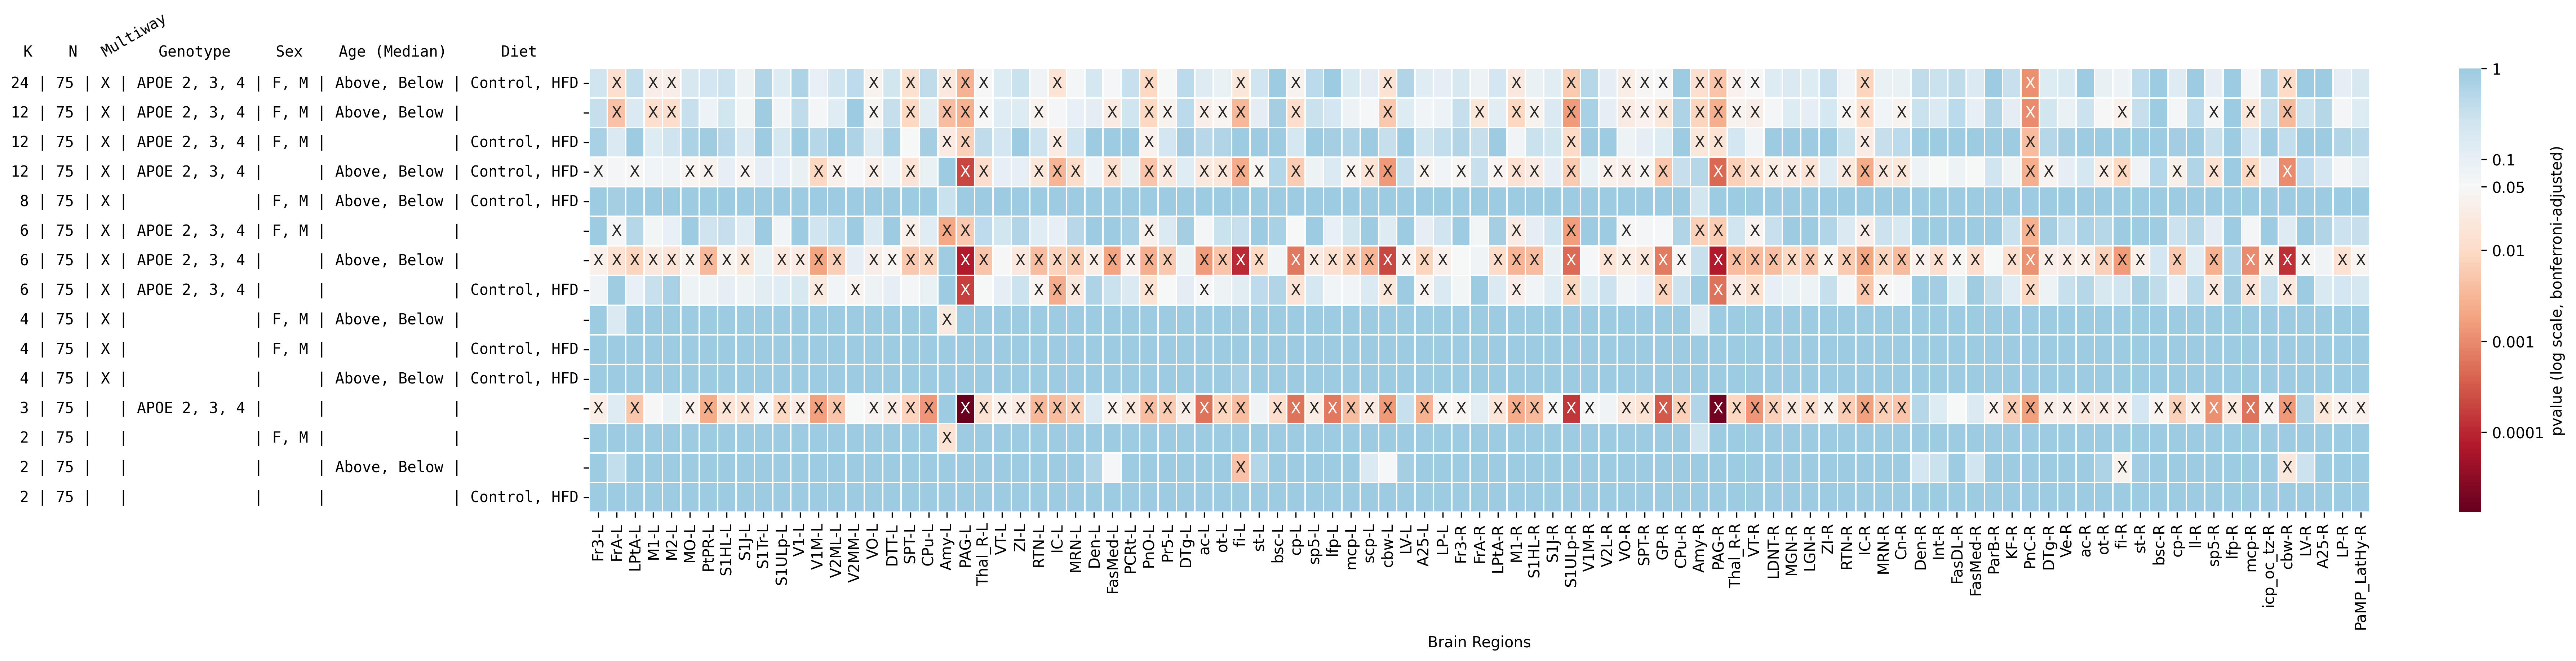

In [333]:
rows_to_choose = np.arange(15)

tmp = pvalues.iloc[rows_to_choose]

nodes_to_choose = ((tmp <= 0.05).sum() >= 1).values
# pvalues.columns = node_labels["Abbreviation"].values
tmp.columns = node_labels["Abbreviation-Hemisphere"].values
# pvalues = pvalues[sorted(pvalues.columns)]

left_idx = nodes_to_choose & left_nodes
right_idx = nodes_to_choose & right_nodes

cbar_ticks = [
    0.000000001,
    0.00000001,
    0.0000001,
    0.000001,
    0.00001,
    0.0001,
    0.001,
    0.01,
    0.05,
    0.1,
    1,
]

fig, ax = plt.subplots(figsize=(24, 6), dpi=300, constrained_layout=True)
sns.heatmap(
    tmp.transform("log10").iloc[rows_to_choose, nodes_to_choose],
    ax=ax,
    annot=mask[:, nodes_to_choose][rows_to_choose, :],
    fmt="",
    square=False,
    linewidths=0.5,
    center=np.log10(0.05),
    cbar_kws={"ticks": np.log10(cbar_ticks)},
    cmap="RdBu",
    # xticklabels=False,
)

ax.collections[0].colorbar.set_label("pvalue (log scale, bonferroni-adjusted)")
ax.collections[0].colorbar.set_ticklabels(cbar_ticks)

ax.set_yticklabels(ax.get_yticklabels(), ha="right", fontdict={"family": "monospace"})
ax.set_xlabel("Brain Regions")
# ax.set_title("Effect of Diet")

text_dict = dict(ha="left", va="bottom", transform=ax.transAxes, family="monospace")

# ax.text(-0.87, 1.02, "K", **text_dict)
# ax.text(-0.79, 1.02, "N", **text_dict)
ax.text(-0.275, 1.02, "Multiway", rotation=30, **text_dict)
# ax.text(-0.65, 1.02, "Genotype", **text_dict)
# ax.text(-0.465, 1.02, "Sex", **text_dict)
# ax.text(-0.365, 1.02, "Median Age", **text_dict)
# ax.text(-0.125, 1.02, "Diet", **text_dict)

header = "K    N         Genotype     Sex    Age (Median)      Diet"
ax.text(-0.3175, 1.02, header, **text_dict)

fig.savefig(
    "../results/figures/diet_tests_significant_only.png", bbox_inches="tight", dpi=300
)

fig.savefig(
    "../results/figures/diet_tests_significant_only.svg", bbox_inches="tight", dpi=300
)

In [439]:
rows_to_choose = np.arange(15)

tmp = pvalues.iloc[rows_to_choose]

In [443]:
regions = []
idxes = []

for idx, row in tmp.iterrows():
    row = row[row <= 0.05]
    regions.append(list(np.argsort(row)[:5].index))

    idxes.append(idx)

regions = pd.DataFrame([regions[0]] + regions[-4:-1] + [regions[-1]])

regions = regions.T

regions.columns = ["Genotype + Sex + Age + Diet", "Genotype", "Sex", "Age", "Diet"]

for idx, row in regions.iterrows():
    for key, val in row.items():
        if val is None:
            continue
        splits = val.split("-")
        if splits[1] == "L":
            hemi = "Left"
        else:
            hemi = "Right"
        new_val = node_labels[
            (node_labels.Abbreviation == splits[0]) & (node_labels.Hemisphere == hemi)
        ].Structure.iloc[0]
        new_val = new_val + "-" + splits[1]
        new_val = new_val.replace("_", " ")
        row[key] = new_val

In [444]:
regions

,Genotype + Sex + Age + Diet,Genotype,Sex,Age,Diet
0,Frontal Association Cortex-L,Frontal Cortex Area 3-L,Amygdala-L,Fimbria-L,None
1,Primary Motor Cortex-L,Lateral Parietal Association Cortex-L,None,Fimbria-R,None
2,Secondary Motor Cortex-L,Medial Orbital Cortex-L,None,Cerebellar White Matter-R,None
3,Ventral Orbital Cortex-L,Parietal Cortex Posterior Area Rostral Part-L,None,None,None
4,Septum-L,Primary Somatosensory Cortex Hindlimb Region-L,None,None,None


In [445]:
print(regions.to_latex(index=False))

\begin{tabular}{lllll}
\toprule
 Genotype + Sex + Age + Diet &                                       Genotype &        Sex &                       Age & Diet \\
\midrule
Frontal Association Cortex-L &                        Frontal Cortex Area 3-L & Amygdala-L &                 Fimbria-L & None \\
      Primary Motor Cortex-L &          Lateral Parietal Association Cortex-L &       None &                 Fimbria-R & None \\
    Secondary Motor Cortex-L &                        Medial Orbital Cortex-L &       None & Cerebellar White Matter-R & None \\
    Ventral Orbital Cortex-L &  Parietal Cortex Posterior Area Rostral Part-L &       None &                      None & None \\
                    Septum-L & Primary Somatosensory Cortex Hindlimb Region-L &       None &                      None & None \\
\bottomrule
\end{tabular}



/tmp/ipykernel_45976/1377329203.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(regions.to_latex(index=False))
